
## Сонарные данные

### Определение камня или мины

Сонар (ультразвуковой локатор) - это техника использования звука для навигации, коммуникации с объектами и определения объектов на воде или под водой, например морских судов.

<img src="sonar.jpg"  style="max-height: 500px; max-width: 500px;">

Данный набор данных содержит ответные метрики для 60 различных частот сонара, отправленных на известные объекты - мины и камни. Для каждого отправленного и полученного сигнала были записаны данные об объекте, на который направлялся сонар (мина или камень). 

<img src="mine.jpg"  style="max-height: 500px; max-width: 500px;">

Наша цель - создать модель машинного обучения, которая может определить тип объекта - мина или камень - на основе ответа от сонаров на 60 различных частотах.


Источник данных: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

**Выполним ячейки ниже, чтобы загрузить данные.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv('..\\DATA\\sonar.all-data.csv')

In [63]:
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Freq_1   208 non-null    float64
 1   Freq_2   208 non-null    float64
 2   Freq_3   208 non-null    float64
 3   Freq_4   208 non-null    float64
 4   Freq_5   208 non-null    float64
 5   Freq_6   208 non-null    float64
 6   Freq_7   208 non-null    float64
 7   Freq_8   208 non-null    float64
 8   Freq_9   208 non-null    float64
 9   Freq_10  208 non-null    float64
 10  Freq_11  208 non-null    float64
 11  Freq_12  208 non-null    float64
 12  Freq_13  208 non-null    float64
 13  Freq_14  208 non-null    float64
 14  Freq_15  208 non-null    float64
 15  Freq_16  208 non-null    float64
 16  Freq_17  208 non-null    float64
 17  Freq_18  208 non-null    float64
 18  Freq_19  208 non-null    float64
 19  Freq_20  208 non-null    float64
 20  Freq_21  208 non-null    float64
 21  Freq_22  208 non

## Исследование данных

**Нарисуем тепловую карту heatmap, показывающую корреляцию между откликами на различных частотах.**

In [16]:
mask = np.zeros((60,60))
mask[np.triu_indices_from(mask)] = 1 

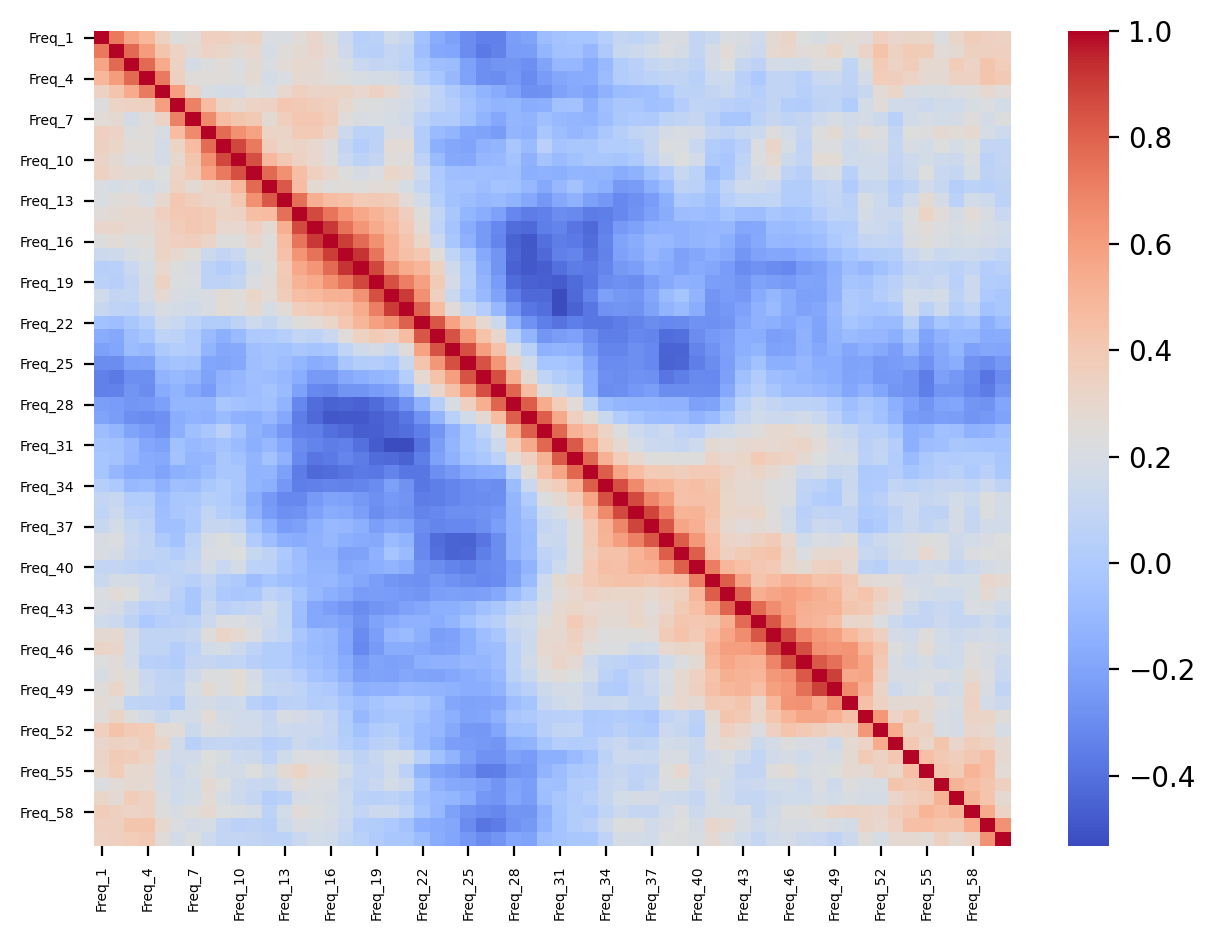

In [33]:
plt.figure(dpi=200)
plot = sns.heatmap(data=df.drop('Label', axis=1).corr(),cmap='coolwarm')
plot.tick_params(axis='both', labelsize=5)
plt.tight_layout()

**Выясним, какие 5 частот лучше всего коррелируют с целевой переменной**

In [64]:
df2 = df.copy()
df2.Label = df.Label.apply(lambda x: 1 if x == 'M' else 0)

In [75]:
abs(df2.corr()['Label']).sort_values(ascending=False)[:6]

Label      1.000000
Freq_11    0.432855
Freq_12    0.392245
Freq_49    0.351312
Freq_10    0.341142
Freq_45    0.339406
Name: Label, dtype: float64

## Разбиение на обучающий и тестовый наборы данных

Здесь мы будем использовать кросс-валидацию на 90% данных, и затем оценим результаты работы нашей модели на тестовом наборе данных в 10%.

**Разделим данные на признаки и целевую переменную, а затем разобьем все данные на обучающий и тестовый наборы данных, в отношении 90% и 10%.**

In [76]:
from sklearn.model_selection import train_test_split

In [78]:
X = df.drop('Label', axis=1)
y = df.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**ЗАДАНИЕ: Создадим объект PipeLine, в котором будет StandardScaler и модель KNN**

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [91]:
scaler = StandardScaler()
knn_model = KNeighborsClassifier()
pipe = Pipeline([('scaler', scaler),('knn_model', knn_model)])
k_values = list(range(1,30))
param_grid = {'knn_model__n_neighbors' : k_values }

In [99]:
grid_model = GridSearchCV(pipe,param_grid, cv=5, scoring='accuracy')

**С помощью пайплайна выполним поиск по сетке для различных значений k, и выведем наилучшие параметры.**

In [105]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn_model', KNeighborsClassifier())]),
             param_grid={'knn_model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19, 20, 21, 22, 23,
                                                    24, 25, 26, 27, 28, 29]},
             scoring='accuracy')

In [110]:
grid_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn_model', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn_model': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn_model__algorithm': 'auto',
 'knn_model__leaf_size': 30,
 'knn_model__metric': 'minkowski',
 'knn_model__metric_params': None,
 'knn_model__n_jobs': None,
 'knn_model__n_neighbors': 1,
 'knn_model__p': 2,
 'knn_model__weights': 'uniform'}

**Используя словарь .cv_results_, нарисуем график средних тестовых оценок (mean_test_score) для каждого значения K.**

In [124]:
errors = grid_model.cv_results_['mean_test_score']
#k_values = grid_model.cv_results_

masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                   17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False],
       fill_value='?',
            dtype=object)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

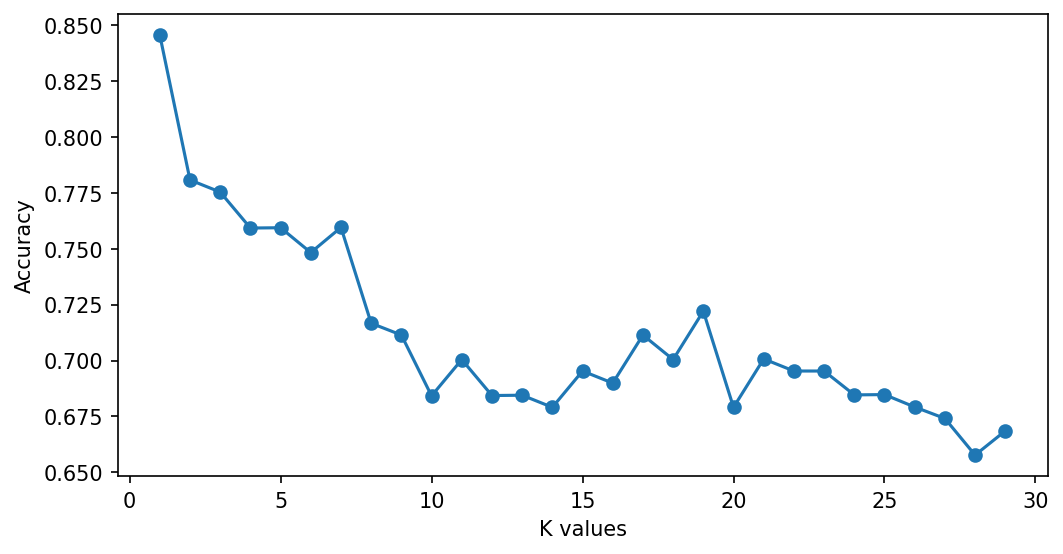

In [136]:
plt.figure(figsize=(8,4), dpi=150)
plt.plot(list(range(1,30)), errors, ls='-', marker='o' )
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.tight_layout

### Финальная оценка модели

**Используя объект grid classifier с предыдущего шага, создадим финальный отчёт "classification report" и матрицу "confusion matrix".**

In [137]:
from sklearn.metrics import classification_report, confusion_matrix

In [139]:
y_pred = grid_model.predict(X_test)

In [141]:
confusion_matrix(y_test, y_pred)

array([[12,  1],
       [ 1,  7]], dtype=int64)

In [144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           M       0.92      0.92      0.92        13
           R       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21

